In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from skimage import feature
from skimage.morphology import binary_erosion
import torch


In [2]:
def getBorderColor(img):
    
    border = np.asarray(img[0,:])
    border = np.concatenate((border, np.asarray(img[-1, :])))
    border = np.concatenate((border, np.asarray(img[:, 0])))
    border = np.concatenate((border, np.asarray(img[:, -1])))
    return np.bincount(border).argmax()


def pre_processing(img):
    _, img_binarized = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)    
    if(getBorderColor(img_binarized) != 0):
        img_binarized = cv2.bitwise_not(img_binarized) 
    return img_binarized



def showImage(img):
    plt.imshow(img, cmap='gray')
    plt.show()    



def getFeaturesHOG(img):
   img = cv2.resize(img, (256, 128))
   cell_size = (32, 32)  # h x w in pixels
   block_size = (2, 2)  # h x w in cells
   nbins = 9  # number of orientation bins
   # winSize is the size of the image cropped to an multiple of the cell size
   hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                    img.shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

   hog_feats = hog.compute(img)
   return hog_feats.flatten()     

# Read Data, Split Training, Validation, Test

In [3]:
data_set = []
Y = []
for i in range(1, 10):
    for filename in os.listdir("ACdata_base/" + str(i)):
        img = cv2.imread(os.path.join("ACdata_base/" + str(i),filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            data_set.append(pre_processing(img))
            Y.append(i)
            
X_train, X_testValid, Y_train, Y_testValid = train_test_split(data_set, Y, test_size=0.4, random_state=42)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_testValid, Y_testValid, test_size=0.5, random_state=42)            

In [4]:
def getFeatures(images):
   x_features = []
   for i in range(len(images)):
        x_features.append(getFeaturesHOG(images[i]))
   return np.asarray(x_features)

In [5]:
train_features = getFeatures(X_train)
validation_features = getFeatures(X_validation)
test_features = getFeatures(X_test)


print(train_features.shape)
print(len(Y_train))

print(validation_features.shape)
print(len(Y_validation))

print(test_features.shape)
print(len(Y_test))


(1011, 756)
1011
(337, 756)
337
(337, 756)
337


In [107]:
# arr = np.array([[1,2,3],[4,5,6],[7,8,9], [10,11,12]])
# a,b = baseline_estimatator(arr)


[ 6 15 24 33]


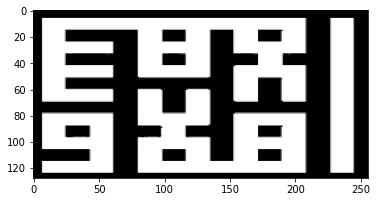

[    0     0     0     0     0     0 55952 55952 55952 55952 55952 55952
 55952 55952 54121 28003 28230 28230 28230 28229 28230 28230 28229 28231
 46627 46627 46627 46626 46628 46627 46627 46627 46626 24506 23439 23439
 23439 23439 23439 23439 23438 23439 46416 46627 46627 46626 46626 46628
 46627 46628 46627 32117 18538 18651 18651 18651 18651 18650 18651 18651
 34308 37554 37554 37552 37552 37554 37554 37553 37554 32104 14115 14114
 14115 14116 14114 14115 14115 14114 32334 46627 46628 46626 46626 46627
 46627 46628 46627 46395 27744 27724 27975 27975 27975 27975 27974 27916
 32065 46627 46627 46628 46626 46627 46627 46627 46628 46627 28230 28230
 28229 28230 28230 28230 28228 28230 28230 51163 51163 51163 51164 51163
 51164 51163 51163 51163     0     0     0     0]
6 6
[ 0.     4.125 12.375 ...  0.     0.     0.   ]


C:\Users\hossa\AppData\Local\Temp/ipykernel_11012/817091747.py:26: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(binary_erosion(255 - img, k2) * binary_erosion(img, k1)) / height
C:\Users\hossa\AppData\Local\Temp/ipykernel_11012/817091747.py:40: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(binary_erosion(255 - img, k2) * binary_erosion(img, k1)) / height
C:\Users\hossa\AppData\Local\Temp/ipykernel_11012/817091747.py:54: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(binary_erosion(255 - img, k2) * binary_erosion(img, k1)) / height
C:\Users\hossa\AppData\Local\Temp/ipykernel_11012/817091747.py:68: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(binary_erosion(255 - img, k2) * binary_erosion(img, k1)) / height
C:\Users\hossa\AppData\Local\Temp/ipykernel_11012/817091747.py:82: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(binary_erosion(255 - img, k2) * bina

In [112]:
# pre processing of the image (baseline estimation)
def baseline_estimatator(img):
    horz_proj = np.sum(img, 1)
    print(horz_proj)
    lb = np.argmax(horz_proj)
    
    avg_row_density = np.average(horz_proj)
    for inx, row_proj in enumerate(horz_proj):
        if row_proj >= avg_row_density:
            lu = inx
            break
    print(lb, lu)    
    return lb,lu

def leftUp(img, height):
    k1 = np.array([
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 0]
    ])
    k2 = np.array([
        [0, 0, 1],
        [0, 1, 1],
        [1, 1, 0]
    ])    
    return np.sum(binary_erosion(255 - img, k2) * binary_erosion(img, k1)) / height


def rightUp(img, height):
    k1 = np.array([
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 0]
    ])
    k2 = np.array([
        [1, 0, 0],
        [1, 1, 0],
        [0, 1, 1]
    ])    
    return np.sum(binary_erosion(255 - img, k2) * binary_erosion(img, k1)) / height


def rightDown(img, height):
    k1 = np.array([
        [0, 0, 0],
        [0, 0, 1],
        [0, 1, 0]
    ])
    k2 = np.array([
        [0, 1, 1],
        [1, 1, 0],
        [1, 0, 0]
    ]) 
    return np.sum(binary_erosion(255 - img, k2) * binary_erosion(img, k1)) / height


def leftDown(img, height):
    k1 = np.array([
        [0, 0, 0],
        [1, 0, 0],
        [0, 1, 0]
    ])
    k2 = np.array([
        [1, 1, 0],
        [0, 1, 1],
        [0, 0, 1]
    ]) 
    return np.sum(binary_erosion(255 - img, k2) * binary_erosion(img, k1)) / height


def vertical(img, height):
    k1 = np.array([
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]
    ])
    k2 = np.array([
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]
    ]) 
    return np.sum(binary_erosion(255 - img, k2) * binary_erosion(img, k1)) / height


def horizontal(img, height):
    k1 = np.array([
        [0, 0, 0],
        [0, 0, 0],
        [1, 1, 1]
    ])
    k2 = np.array([
        [0, 0, 0],
        [1, 1, 1],
        [0, 0, 0]
    ])    
    return np.sum(binary_erosion(255 - img, k2) * binary_erosion(img, k1)) / height


def get_center_of_mass(window):
    # calculate moments of binary image
    M = cv2.moments(window)
    # calculate x,y coordinate of center
    cX = int(M["m10"] / (M["m00"] + 1e-5))
    cY = int(M["m01"] / (M["m00"] + 1e-5))
    return cX,cY


def getImageFeatures(img, WIDTH, HEIGHT, STRID, N, baseline):
    lb, lu = baseline
    img_height = img.shape[0]
    img_width = img.shape[1]
    f1 = []
    f2 = []
    f3 = []
    f4 = []
    f5 = []
    f6 = []
    f7 = []
    f8 = []
    f9 = []
    f10 = []
    f11 = []
    f12 = []
    f13 = []
    f14 = []
    f15 = []
    f16 = []
    f17 = []
    f18 = []
    f19 = []
    f20 = []
    f21 = []
    f22 = []
    f23 = []
    f24 = []
    f25 = []
    f26 = []
    f27 = []
    f28 = []
    centers = []
    k = -1
    index = 0
    for c in range(0, img_height, HEIGHT):
        if c >= lb:
            k = c
            break
        index += 1
    
    for r in range(img_width - 1, WIDTH - 1, -STRID):
        window = img[:, r-WIDTH:r]
        centers.append(get_center_of_mass(window))
        f5.append(np.sum(img[0:lb-1, r-WIDTH:r] == 255) / (lb * WIDTH))
        f6.append(np.sum(img[lb:, r-WIDTH:r] == 255) / ((img_height - lb) * WIDTH))
        foreground = []
        cells = []
        for c in range(0, img_height, HEIGHT):
            window_2 = img[c:c+HEIGHT-1, r-WIDTH:r]
            foreground.append(np.sum(window_2 == 255) / (WIDTH * HEIGHT))
            cells.append(window_2)
        f1.append(np.sum(foreground))
        summtion = 0
        for i in range(2,N):
            bi = int(np.sum(cells[i] == 255) == 0)
            b_i = int(np.sum(cells[i - 1] == 255) == 0)
            summtion += np.abs(bi - b_i )
        f2.append(summtion)
        cells = []
        for c in range(0, k, HEIGHT):
            cells.append(img[c:c+HEIGHT-1, r-WIDTH:r])
        summtion = 0
        for i in range(2, len(cells)):
            bi = int(np.sum(cells[i] == 255) == 0)
            b_i = int(np.sum(cells[i - 1] == 255) == 0)
            summtion += np.abs(bi - b_i)
        f7.append(summtion)
        center_y = get_center_of_mass(window)[1]
        if center_y > lb:
            f8.append(3)
        elif center_y < lb and center_y > lu:
            f8.append(2)
        else:
            f8.append(1)
        f9.append(leftUp(window, img_height))
        f10.append(rightUp(window, img_height))
        f11.append(rightDown(window, img_height))
        f12.append(leftDown(window, img_height))
        f13.append(vertical(window, img_height))
        f14.append(horizontal(window, img_height))
        window = img[lu:lb, r-WIDTH:r]
        f15.append(leftUp(window, np.abs(lb-lu)))
        f16.append(rightUp(window, np.abs(lb-lu)))
        f17.append(rightDown(window, np.abs(lb-lu)))
        f18.append(leftDown(window, np.abs(lb-lu)))
        f19.append(vertical(window, np.abs(lb-lu)))
        f20.append(horizontal(window, np.abs(lb-lu)))
        window = img[lu:lb, r-WIDTH:r]
        f21.append(np.sum(window[:, 0]) / img_height)
        f22.append(np.sum(window[:, 1]) / img_height)
        f23.append(np.sum(window[:, 2]) / img_height)
        f24.append(np.sum(window[:, 3]) / img_height)
        f25.append(np.sum(window[:, 4]) / img_height)
        f26.append(np.sum(window[:, 5]) / img_height)
        f27.append(np.sum(window[:, 6]) / img_height)
        f28.append(np.sum(window[:, 7]) / img_height)


    f3.append(np.sqrt(np.power(centers[0][0], 2) + np.power(centers[0][1], 2)))
    for i in range(1,len(centers)):
        f3.append(np.sqrt(np.power(centers[i][0] - centers[i - 1][0],
                        2) + np.power(centers[i][1] - centers[i - 1][1], 2)))
    for i in range(0, len(centers)):
        f4.append(np.sqrt(np.power(centers[i][1] - lb, 2) / img_height))

    features_list = f1+f2+f3+f4+f5+f6+f7+f8+f9+f10+f11+f12+f13+f14+f15+f16+f17+f18+f19+f20+f21+f22+f23+f24+f25+f26+f27+f28 
    return np.asarray(features_list)


N = 20
WIDTH = 8 
STRID = 4
img = X_train[48]
img = cv2.resize(img, (256, 128))
showImage(img)
#print(img.shape)

f = (getImageFeatures(img, WIDTH, int(img.shape[0] / N), STRID, N, baseline_estimatator(img)))
print(f)

In [69]:
def getFeatures28(images):
   N = 20
   WIDTH = 8 
   STRID = 4
   x_features = []
   for i in range(len(images)):
        img = images[i]
        print(i)
        #img = cv2.resize(images[i], (256, 128))
        x_features.append(getImageFeatures(img, WIDTH, int(img.shape[0] / N), STRID, N, baseline_estimatator(img)))
   return np.asarray(x_features)


features28_training = getFeatures28(X_train)
features28_validation = getFeatures28(X_validation)
features28_test = getFeatures28(X_test)

print(features28_training.shape)
print(len(Y_train))

print(features28_validation.shape)
print(len(Y_validation))

print(features28_test.shape)
print(len(Y_test))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48


C:\Users\hossa\AppData\Local\Temp/ipykernel_11012/3056625644.py:24: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(binary_erosion(255 - img, k2) * binary_erosion(img, k1)) / height
C:\Users\hossa\AppData\Local\Temp/ipykernel_11012/3056625644.py:38: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(binary_erosion(255 - img, k2) * binary_erosion(img, k1)) / height
C:\Users\hossa\AppData\Local\Temp/ipykernel_11012/3056625644.py:52: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(binary_erosion(255 - img, k2) * binary_erosion(img, k1)) / height
C:\Users\hossa\AppData\Local\Temp/ipykernel_11012/3056625644.py:66: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(binary_erosion(255 - img, k2) * binary_erosion(img, k1)) / height
C:\Users\hossa\AppData\Local\Temp/ipykernel_11012/3056625644.py:80: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(binary_erosion(255 - img, k2) *

IndexError: index 0 is out of bounds for axis 0 with size 0

In [6]:
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = train_features.shape[0], train_features.shape[1], 512, 9


# Create random Tensors to hold inputs and outputs
x = torch.tensor(train_features)
y = torch.tensor(Y_train)
y = y-1 #output layer nodes indices [0:8] not [1:9]

x_validation = torch.tensor(validation_features)
Y_validation = torch.tensor(Y_validation)
Y_validation = Y_validation - 1

x_test = torch.tensor(test_features)
y_test = torch.tensor(Y_test)
y_test = y_test - 1

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.LogSoftmax(dim=1)
)

loss_fn = torch.nn.NLLLoss()

learning_rate = 1e-4


model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

training_losses = []
validation_losses = []

In [11]:
for t in range(1000):

    x = x.to(device)
    y = y.to(device)
    
    y_pred = model(x)

    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item(),"  [Training]")
        training_losses.append(loss.item())
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if t % 100 == 99:
        with torch.no_grad():
            x_valid = x_validation.to(device)
            y_valid = Y_validation.to(device)
            y_pred2 = model(x_valid)
            loss = loss_fn(y_pred2, y_valid)
            print(t, loss.item(),"  [Validation]" )
            validation_losses.append(loss.item())


99 0.788316011428833   [Training]
99 0.8408178687095642   [Validation]
199 0.49566081166267395   [Training]
199 0.5953730940818787   [Validation]
299 0.34526288509368896   [Training]
299 0.4780306816101074   [Validation]
399 0.2556755542755127   [Training]
399 0.4151846766471863   [Validation]
499 0.19488833844661713   [Training]
499 0.378095805644989   [Validation]
599 0.15034541487693787   [Training]
599 0.35524502396583557   [Validation]
699 0.11652354896068573   [Training]
699 0.34106674790382385   [Validation]
799 0.09076791256666183   [Training]
799 0.33274826407432556   [Validation]
899 0.07104741036891937   [Training]
899 0.3280278742313385   [Validation]
999 0.05607368052005768   [Training]
999 0.3262142837047577   [Validation]


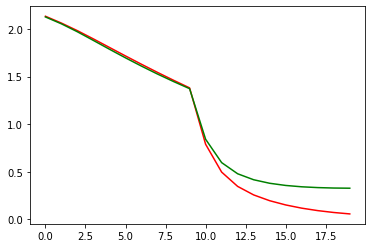

In [12]:
plt.plot(training_losses, '-r')
plt.plot(validation_losses, '-g')
plt.show()         

In [13]:
with torch.no_grad():
    y_pred = model(x)
    y_pred = torch.argmax(torch.exp(y_pred), dim=1)
    acc = (torch.sum(y_pred==y).item() / len(y)) * 100
    print("Training Accuracy = ", acc, "%")    

    x_valid = x_validation.to(device)
    y_valid = Y_validation.to(device)
    y_pred = model(x_valid)
    y_pred = torch.argmax(torch.exp(y_pred), dim=1)
    acc = (torch.sum(y_pred==y_valid).item() / len(y_valid)) * 100
    print("Validation Accuracy = ", acc, "%")

    x_test = x_test.to(device)
    y_test = y_test.to(device)

    y_pred = model(x_test)
    y_pred = torch.argmax(torch.exp(y_pred), dim=1)
    acc = (torch.sum(y_pred==y_test).item() / len(y_test)) * 100
    print("Test Accuracy = ", acc, "%")

Training Accuracy =  99.70326409495549 %
Validation Accuracy =  89.02077151335311 %
Test Accuracy =  91.0979228486647 %
